In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

from sklearn import datasets
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_regression
import warnings
import seaborn as sns

%matplotlib inline
import scipy.stats as stats
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [3]:
print("Skew is:", train.SalePrice.skew()) # Original Skewness

target = np.log(train.SalePrice)
print("Skew is:", target.skew()) # log is used to improve skewness
# Now there's a normal distribution (as skewness is close to zero)

Skew is: 1.8828757597682129
Skew is: 0.12133506220520406


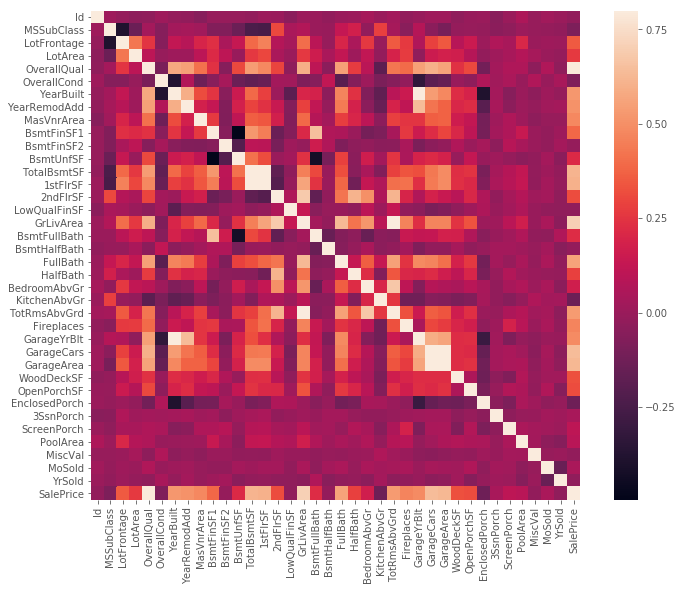

In [4]:
numeric_features = train.select_dtypes(include=[np.number])
corr = numeric_features.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True)

In [5]:
corr["SalePrice"].sort_values(ascending=False)
# shows Quantitative features correlation with SalePrice

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


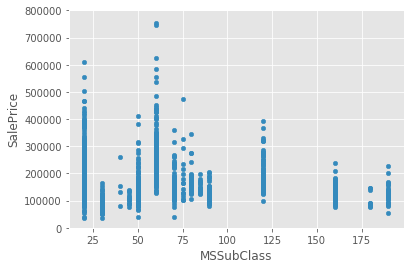

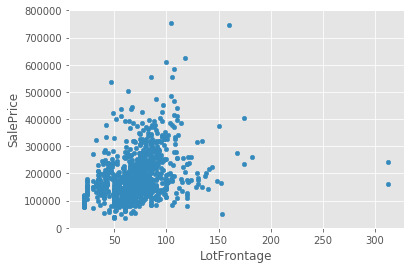

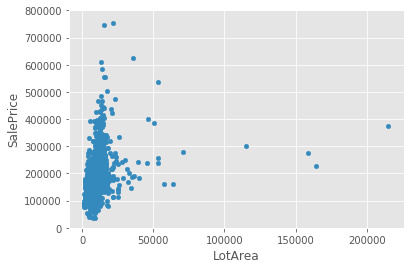

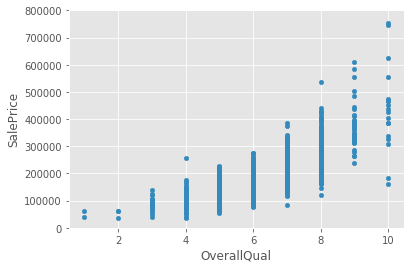

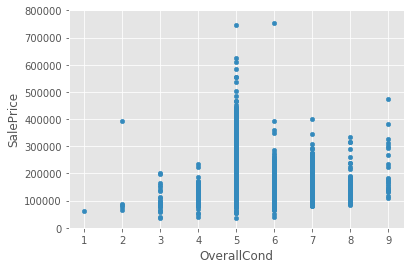

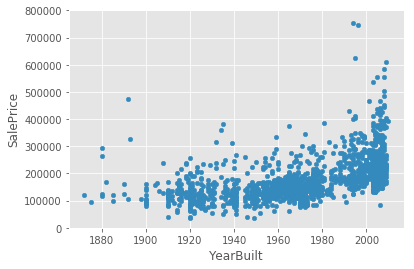

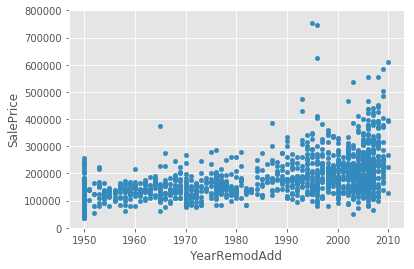

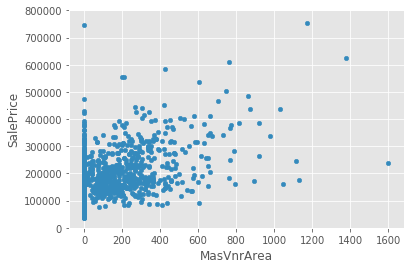

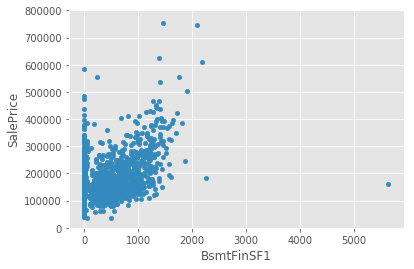

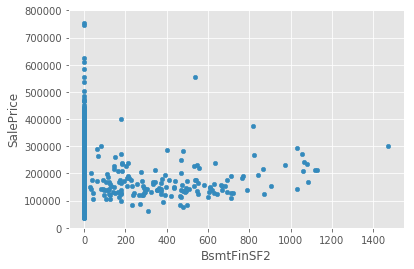

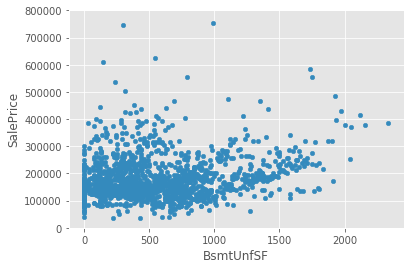

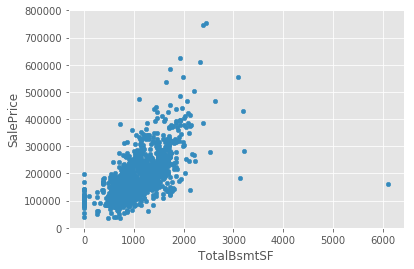

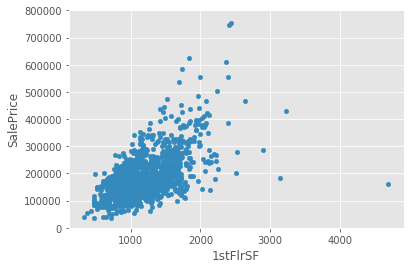

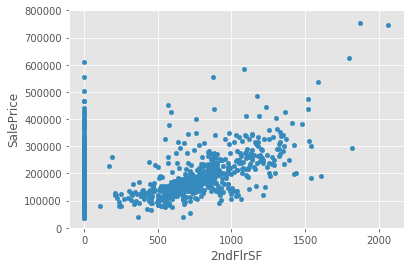

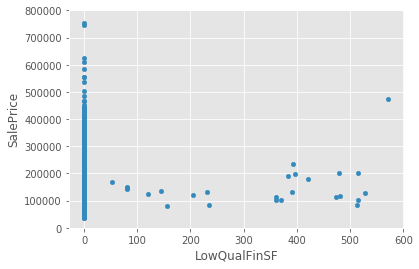

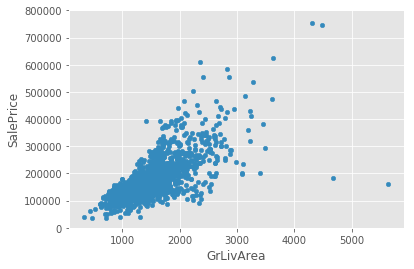

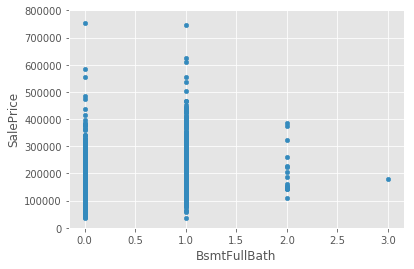

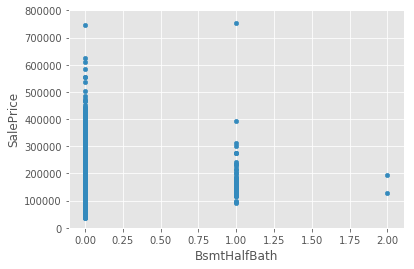

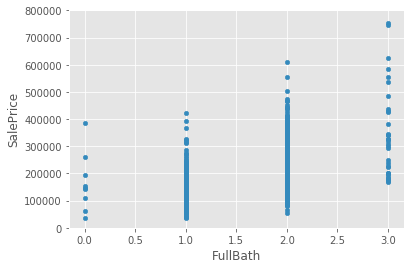

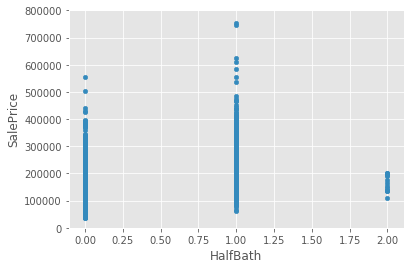

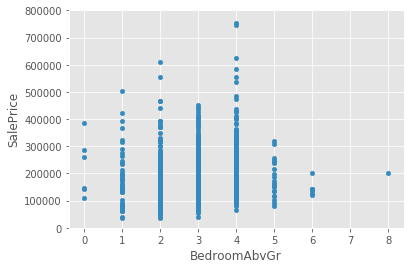

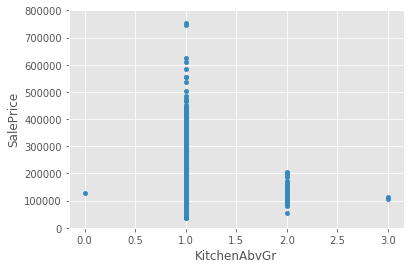

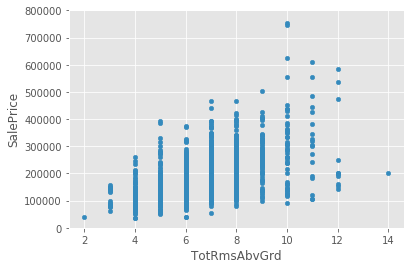

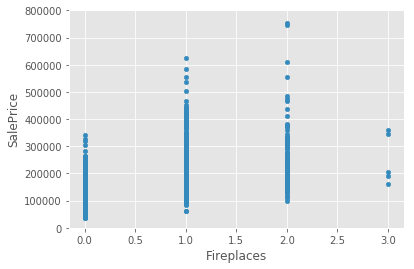

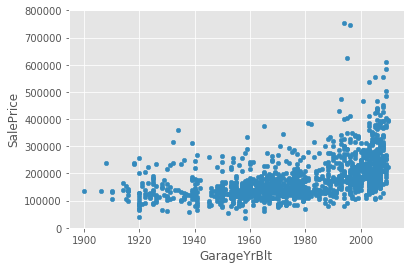

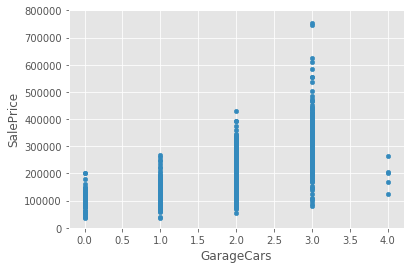

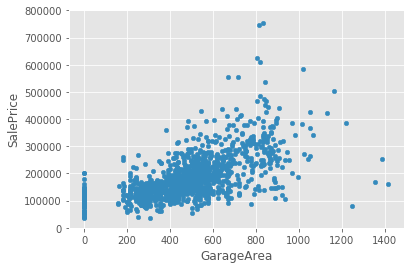

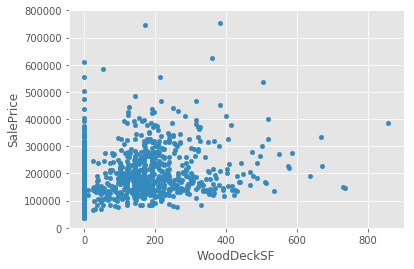

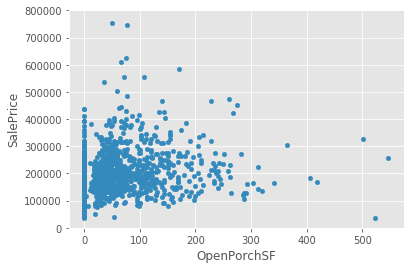

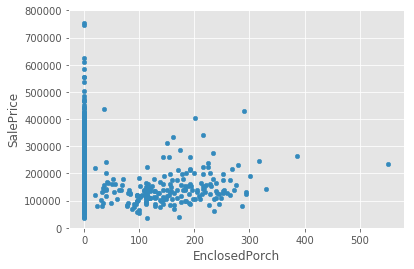

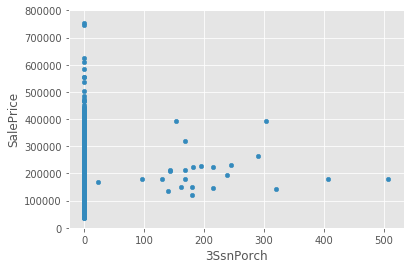

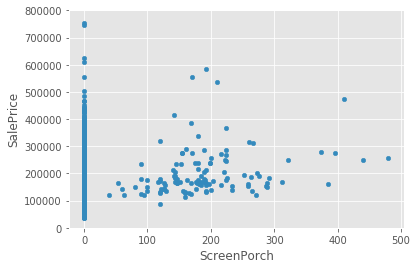

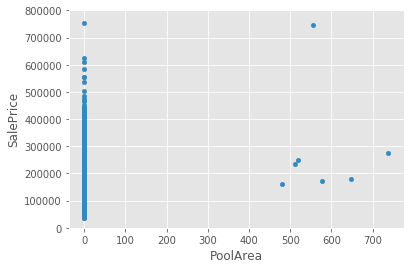

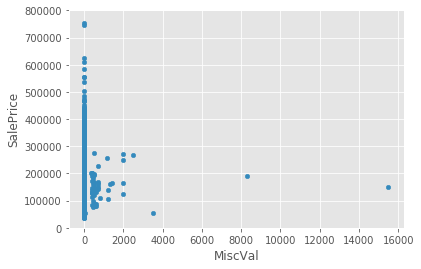

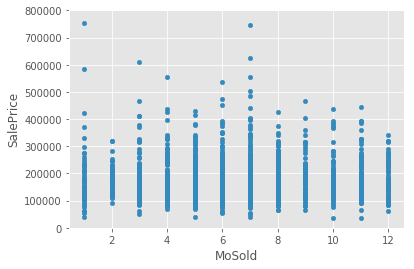

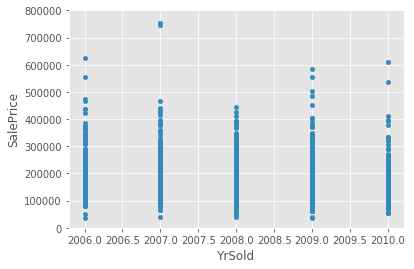

In [6]:
# scatter plots of reletion between SalePrice and numeric/quantitative features

y = np.log(train.SalePrice)
for i in quantitative:
    var = i
    data = pd.concat([train['SalePrice'], train[var]], axis=1)
    data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [7]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, "Enc"+feature] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append("Enc" + q)
print(qual_encoded)

['EncMSZoning', 'EncStreet', 'EncAlley', 'EncLotShape', 'EncLandContour', 'EncUtilities', 'EncLotConfig', 'EncLandSlope', 'EncNeighborhood', 'EncCondition1', 'EncCondition2', 'EncBldgType', 'EncHouseStyle', 'EncRoofStyle', 'EncRoofMatl', 'EncExterior1st', 'EncExterior2nd', 'EncMasVnrType', 'EncExterQual', 'EncExterCond', 'EncFoundation', 'EncBsmtQual', 'EncBsmtCond', 'EncBsmtExposure', 'EncBsmtFinType1', 'EncBsmtFinType2', 'EncHeating', 'EncHeatingQC', 'EncCentralAir', 'EncElectrical', 'EncKitchenQual', 'EncFunctional', 'EncFireplaceQu', 'EncGarageType', 'EncGarageFinish', 'EncGarageQual', 'EncGarageCond', 'EncPavedDrive', 'EncPoolQC', 'EncFence', 'EncMiscFeature', 'EncSaleType', 'EncSaleCondition']


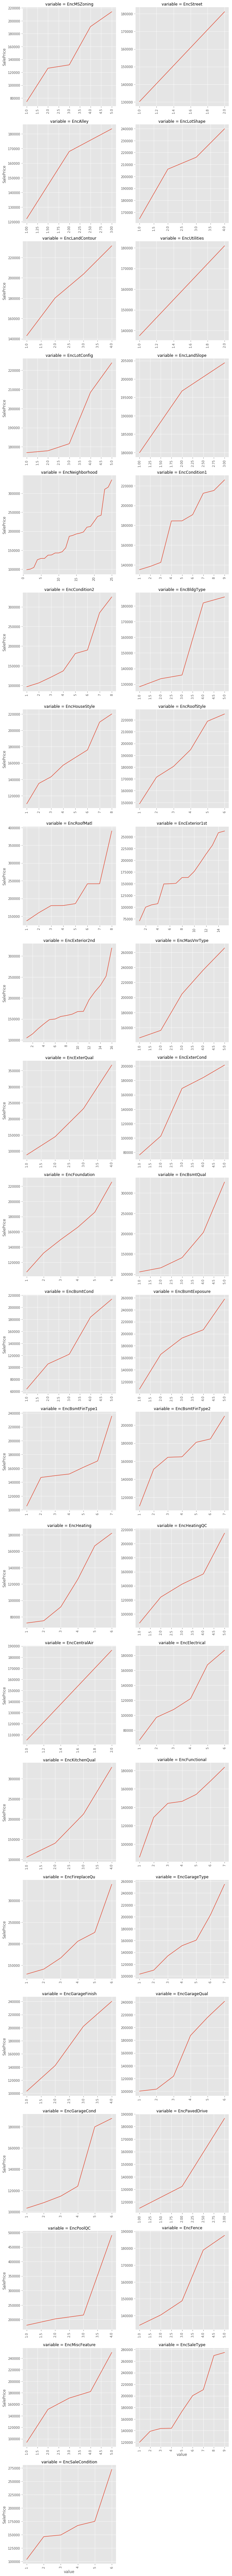

In [8]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

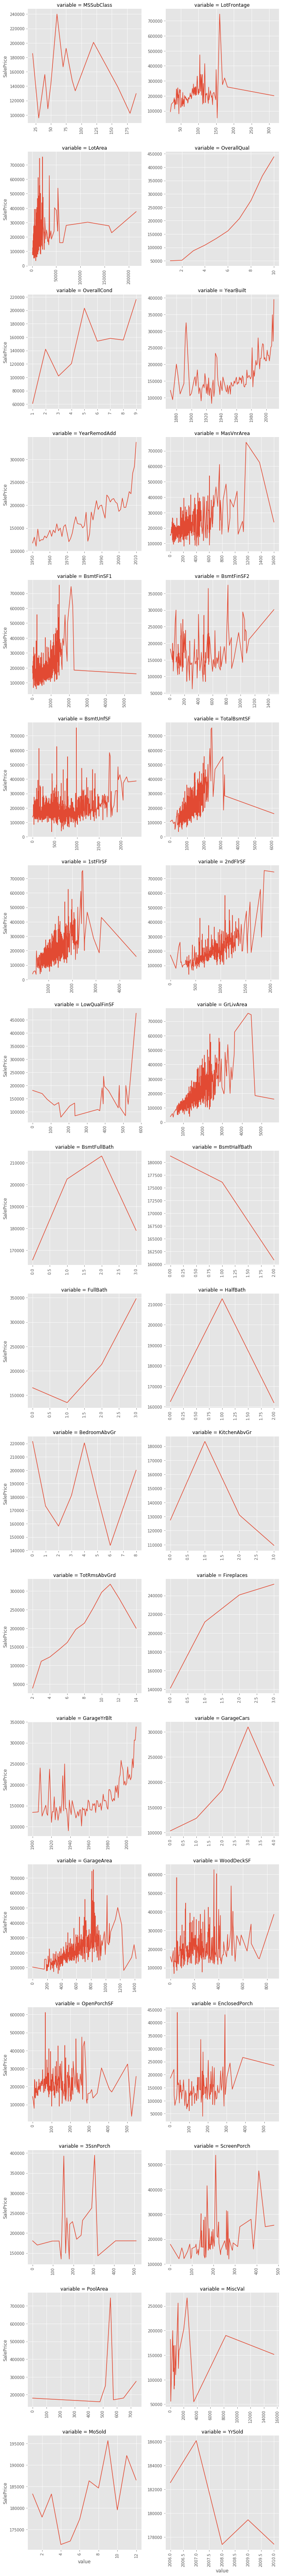

In [9]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

In [10]:
# dropped some features which I didn't consider important when predicting SalePrice of test Data
data = train.drop(["LotFrontage", "BsmtFinSF1", "BsmtUnfSF", "BsmtFinSF2", "YearRemodAdd", "YearBuilt", "PoolArea", "BedroomAbvGr", "EncLotShape", "EncLandSlope", "EncRoofMatl", "EncFoundation", "EncBsmtCond", "EncGarageType", "EncPoolQC", "EncSaleType"], axis=1)

In [11]:
# separate the test data into Quantitative/numeric features and Qualitative features
testQuantitative = [f for f in test.columns if test.dtypes[f] != 'object']
testQuantitative.remove('Id')
testQualitative = [f for f in test.columns if test.dtypes[f] == 'object']

In [12]:
# encode the qualitative featuires of the test set, as done with the qualitative features of the train data

for c in testQualitative:
    test[c] = test[c].astype('category')
    if test[c].isnull().any():
        test[c] = test[c].cat.add_categories(['MISSING'])
        test[c] = test[c].fillna('MISSING')

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    #ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    #ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, "Enc"+feature] = o
    
testQual_encoded = []
for q in testQualitative:  
    encode(test, q)
    testQual_encoded.append("Enc" + q)
testQual_encoded

['EncMSZoning',
 'EncStreet',
 'EncAlley',
 'EncLotShape',
 'EncLandContour',
 'EncUtilities',
 'EncLotConfig',
 'EncLandSlope',
 'EncNeighborhood',
 'EncCondition1',
 'EncCondition2',
 'EncBldgType',
 'EncHouseStyle',
 'EncRoofStyle',
 'EncRoofMatl',
 'EncExterior1st',
 'EncExterior2nd',
 'EncMasVnrType',
 'EncExterQual',
 'EncExterCond',
 'EncFoundation',
 'EncBsmtQual',
 'EncBsmtCond',
 'EncBsmtExposure',
 'EncBsmtFinType1',
 'EncBsmtFinType2',
 'EncHeating',
 'EncHeatingQC',
 'EncCentralAir',
 'EncElectrical',
 'EncKitchenQual',
 'EncFunctional',
 'EncFireplaceQu',
 'EncGarageType',
 'EncGarageFinish',
 'EncGarageQual',
 'EncGarageCond',
 'EncPavedDrive',
 'EncPoolQC',
 'EncFence',
 'EncMiscFeature',
 'EncSaleType',
 'EncSaleCondition']

In [13]:
# dropped some features which I didn't consider important when predicting SalePrice of test Data
testData = test.drop(["LotFrontage", "BsmtFinSF1", "BsmtUnfSF", "BsmtFinSF2", "YearRemodAdd", "YearBuilt", "PoolArea", "BedroomAbvGr", "EncLotShape", "EncLandSlope", "EncRoofMatl", "EncFoundation", "EncBsmtCond", "EncGarageType", "EncPoolQC", "EncSaleType"], axis=1)

In [14]:
for i in testQualitative:
    var = i
    testData = testData.drop([var], axis=1)

In [15]:
data = data.select_dtypes(include=[np.number]).interpolate().dropna()
print(sum(data.isnull().sum() != 0))

0


In [16]:
y = np.log(train.SalePrice)
X = data.drop(["SalePrice", "Id"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=.33)

In [17]:
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

"r^2 is:", model.score(X_test, y_test)

('r^2 is:', 0.8042428041151022)

In [18]:
predictions = model.predict(X_test)
"RMSE is:", mean_squared_error(y_test, predictions)

('RMSE is:', 0.029924978825955472)

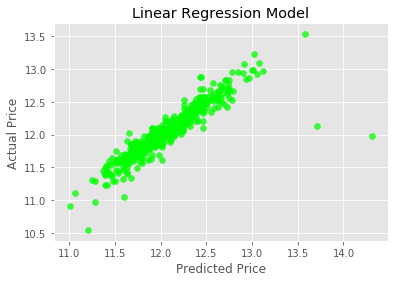

In [19]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75, color="lime")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Linear Regression Model")
plt.show()

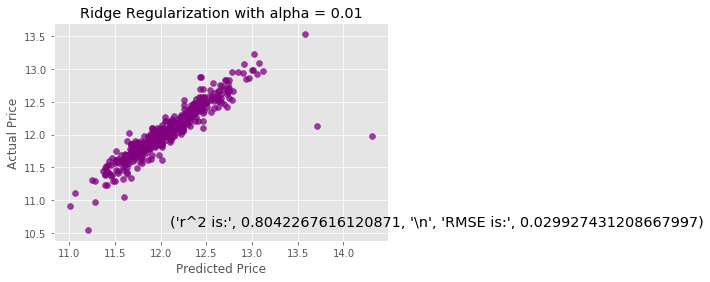

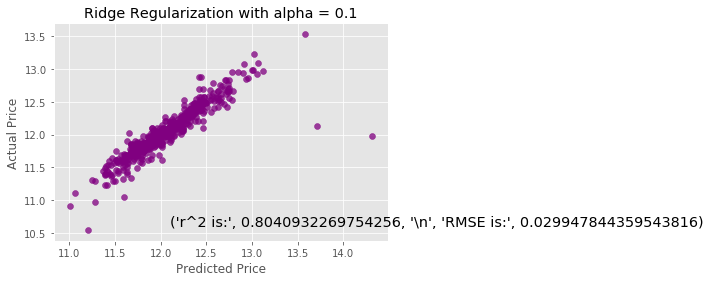

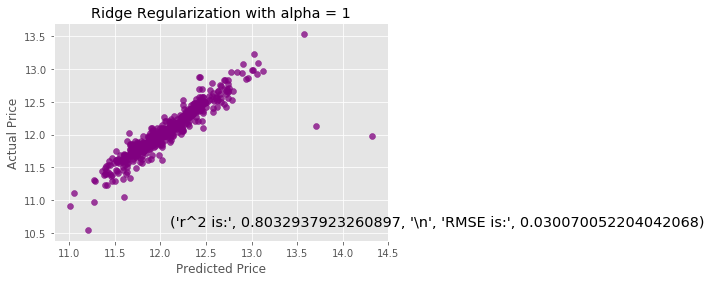

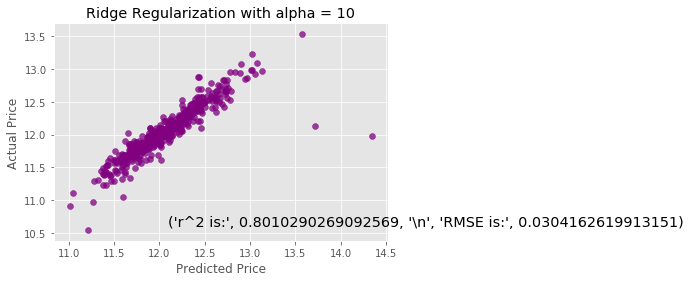

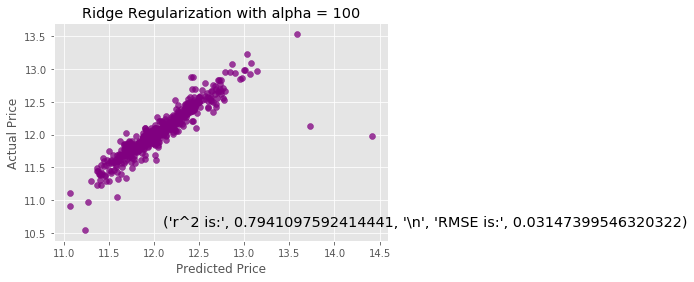

In [20]:
for i in range(-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    pred_ridge = ridge_model.predict(X_test)
    
    plt.scatter(pred_ridge, actual_values, alpha=.75, color="purple")
    plt.xlabel("Predicted Price")
    plt.ylabel("Actual Price")
    plt.title("Ridge Regularization with alpha = {}".format(alpha))
              
    overlay = "r^2 is:", ridge_model.score(X_test, y_test), "\n", "RMSE is:", mean_squared_error(y_test, pred_ridge)
    plt.annotate(s=overlay, xy=(12.1,10.6), size="x-large")
    plt.show()

In [21]:
submission = pd.DataFrame()
submission["Id"] = test.Id

features = testData.select_dtypes(include=[np.number]).drop(["Id"], axis=1).interpolate()
predictions = model.predict(features)
final_pred = np.exp(predictions)

In [22]:
print("Original Predictions are:\n", predictions[:10], "\n")
print("Final Predictions are:\n", final_pred[:10])

Original Predictions are:
 [10.58872535 10.96091981 10.88936475 11.03354116 11.00535722 10.93304957
 11.05732951 10.86849891 11.08268985 10.61606658] 

Final Predictions are:
 [39684.87253787 57579.38099308 53603.23773744 61916.44923093
 60195.76160132 55996.78561188 63406.997571   52496.34953412
 65035.58431105 40784.8749795 ]


In [23]:
submission["SalePrice"] = final_pred
submission.head()

,Id,SalePrice
0,1461,39684.872538
1,1462,57579.380993
2,1463,53603.237737
3,1464,61916.449231
4,1465,60195.761601


In [24]:
submission.to_csv("submission.csv", index=False)